In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from lib.transformers.src.transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
import networkx as nx
from community import community_louvain
from matplotlib import pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from community import community_louvain
import parse as p
import author_network as an
import regression as re
import text_mining as tm

Using TensorFlow backend.


In [2]:
#files = ['../data/icml2019.json']
#files = ['../data/icml2019.json','../data/icml2018.json','../data/icml2017.json']

files = ['../data/icml2019.json','../data/icml2018.json','../data/icml2017.json'
        , '../data/nips2019.json', '../data/nips2018.json', '../data/nips2017.json']

years = '(2017-2019, ICML&NIPS)'
#years = '(2019, ICML)'
re_years = [2017, 2018, 2019]
#re_years = [ 2019]
target = [2020, 2021]
#figsize = (150,150)
figsize = (80,80)
figsize_i = (1000,1000)

DRAW = False

author_list, paper_list = p.parse_json(files)
text = tm.get_title_abstracts(paper_list)

Read 6 files, 4943 papers and 10186 authors


In [3]:
text_ids, text_masks = tm.tokenize_data(text)

Token indices sequence length is longer than the specified maximum sequence length for this model (887 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (859 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Max sentence length:  889
number:4943


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')
    device = torch.device("cpu")

# Using 'BertForSequenceClassification'
model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2,
        output_attentions = True, output_hidden_states = True).to(device)

optimizer = Adam(model.parameters(), lr=1e-6)

Using GPU: GeForce RTX 2080 Ti


In [5]:
BATCH_SIZE = 8

text_inputs = torch.tensor(text_ids)
text_masks = torch.tensor(text_masks)

text_data = TensorDataset(text_inputs, text_masks)
text_sampler = SequentialSampler(text_data)
text_dataloader = DataLoader(text_data, sampler=text_sampler, batch_size=BATCH_SIZE)

In [6]:
def get_vectors(model, dataloader):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0
    total_len = 0
    preds=[]
    pooled_list = []
    for step, batch in enumerate(dataloader):
        # batch: [ids, mask, label]
        b_temp = tuple(b.to(device) for b in batch)
        b_ids, b_mask = b_temp
        
        with torch.no_grad():
            outputs, pooled_data = model(b_ids, token_type_ids=None,
                          attention_mask=b_mask, labels=None)

        pooled_data = pooled_data.detach().cpu()
        tmp_eval_loss, logits, hidden_states = outputs
        
        last_hidden_states = logits[len(logits)-1].detach().cpu()
        batch_preds = last_hidden_states[:,0,:].numpy()
        #print(len(logits), len(hidden_states))
        for vector in pooled_data:
            pooled_list.append(np.array(vector))
    
        if (step%50 == 0):
            print("Batch %.i/%.i" %(step+1, len(dataloader)))
    return preds, pooled_list

In [7]:
_, pooled_data = get_vectors(model, text_dataloader)

Batch 1/618
Batch 51/618
Batch 101/618
Batch 151/618
Batch 201/618
Batch 251/618
Batch 301/618
Batch 351/618
Batch 401/618
Batch 451/618
Batch 501/618
Batch 551/618
Batch 601/618


In [9]:
tm.cos_sim(pooled_data[0], pooled_data[2])

0.5726279

In [10]:
sim_list = tm.top_cos_sim(pooled_data, 5000, 1)

In [11]:
G = tm.make_paper_graph(paper_list, sim_list)

In [12]:
plt.figure(figsize = figsize)
sp = nx.spring_layout(G)
DRAW = False
if (DRAW):
    nx.draw_networkx(G,
                    pos=sp, 
                    with_labels=False,
                    node_size = 500,
                    alpha=0.7,
                    cmap = plt.cm.Set3
                )
    # plt.axes('off')
    plt.title('Total Paper Network')
    plt.show()

<Figure size 5760x5760 with 0 Axes>

In [13]:
flag = True
if (flag):
    values_nv = tm.node2vec_kmeans(G, 50)
    if (DRAW):
        plt.figure(figsize = figsize)
        nx.draw_networkx(G,
                         pos=sp, 
                         with_labels=False, 
                         node_size = 500,
                         node_color=values_nv, 
                         alpha=0.7,
                         cmap = plt.cm.Set3
                        )
        plt.show()

Generating walks (CPU: 1): 100%|██████████| 2000/2000 [22:49<00:00,  1.46it/s]


00, ['Blended Conditonal Gradients', 'Cut-Pursuit Algorithm for Regularizing Nonsmooth Functionals with Graph Total Variation', 'Stochastic Variance-Reduced Cubic Regularized Newton Methods', 'A Nonconvex Approach for Exact and Efficient Multichannel Sparse Blind Deconvolution', 'Unsupervised Scalable Representation Learning for Multivariate Time Series', 'Fast and Accurate Stochastic Gradient Estimation', 'Consistent Robust Regression', 'End-to-end Active Object Tracking via Reinforcement Learning', 'On Adversarial Mixup Resynthesis', 'A Meta-Analysis of Overfitting in Machine Learning']
01, ['Are GANs Created Equal? A Large-Scale Study', 'Cold Case: The Lost MNIST Digits', 'Fast and Sample Efficient Inductive Matrix Completion via Multi-Phase Procrustes Flow', 'Stochastic Variance-Reduced Hamilton Monte Carlo Methods', 'Sparse PCA from Sparse Linear Regression', 'Prox-PDA: The Proximal Primal-Dual Algorithm for Fast Distributed Nonconvex Optimization and Learning Over Networks', 'Str

In [32]:
if (flag):
    fig = tm.make_iplot_fig(G, sp, values_nv, 'YlOrRd', 20, '#ffffff', figsize_i)
    init_notebook_mode(connected=True)
    iplot(fig)

In [15]:
tm.save_topN_paper_csv('../image/paper_topN_group_list(BERT, node2vec)'+years+'.csv', G, paper_list, values_nv, 50)

[(35, 70), (2, 65), (14, 63), (3, 61), (44, 54), (9, 53), (5, 50), (36, 48), (34, 47), (6, 46), (0, 43), (16, 43), (13, 41), (31, 41), (10, 41), (19, 40), (42, 39), (38, 39), (40, 37), (22, 36), (7, 36), (39, 36), (15, 36), (28, 35), (20, 33), (43, 33), (29, 32), (25, 31), (48, 31), (21, 29), (11, 29), (32, 28), (12, 28), (1, 28), (17, 27), (46, 27), (33, 26), (37, 26), (45, 26), (4, 25), (41, 25), (8, 24), (26, 23), (24, 22), (23, 22), (27, 21), (30, 21), (49, 18), (47, 16), (18, 14)]


In [28]:
partition_lou = community_louvain.best_partition(G, weight='weight')
values_lou = [partition_lou.get(node) for node in G.nodes()]

In [29]:
plt.figure(figsize = figsize)
if (DRAW):
    nx.draw_networkx(G,
                     pos=sp, 
                     with_labels=False, 
                     node_size = 500,
                     node_color=values_lou, 
                     alpha=0.7,
                     cmap = plt.cm.Set3
                    )
    plt.show()

<Figure size 5760x5760 with 0 Axes>

In [33]:
fig = tm.make_iplot_fig(G, sp, values_lou, 'YlOrRd', 20, None, figsize_i)
init_notebook_mode(connected=True)
iplot(fig)

In [21]:
tm.save_topN_paper_csv('../image/paper_topN_group_list(BERT, louvain)'+years+'.csv', G, paper_list, values_lou, 50)

[(4, 258), (1, 204), (0, 196), (2, 184), (3, 158), (8, 137), (6, 134), (7, 112), (15, 62), (11, 31), (23, 22), (9, 20), (5, 18), (29, 12), (21, 10), (44, 6), (49, 6), (14, 5), (18, 5), (32, 5), (50, 5), (12, 4), (13, 4), (20, 4), (28, 4), (35, 4), (54, 4), (61, 4), (66, 4), (16, 3), (25, 3), (30, 3), (41, 3), (48, 3), (52, 3), (53, 3), (60, 3), (64, 3), (69, 3), (72, 3), (10, 2), (17, 2), (19, 2), (22, 2), (24, 2), (26, 2), (27, 2), (31, 2), (33, 2), (34, 2)]


In [22]:
def get_paper_vector(G, re_groups, re_papers, years):
    years.sort()
    group_vec = []
    b_year = int(years[0])
    ctr = collections.Counter(values_lou)

    for i in range(len(ctr)):
        group_vec.append([0 for year in years])
        group = re_groups[i]
        
        j = 0
        for node in G:
            if (i == re_groups[j]):
                paper_index = p.find_paper(node, re_papers)
                paper = re_papers[paper_index]
                index = int(paper.year) - b_year
                group_vec[i][index] += 1 #/year_paper[index][1]
            j += 1

    return group_vec

def get_paper_regression(G, re_groups, re_papers, years, target):
    group_vec = get_paper_vector(G, re_groups, re_papers, years)
    total_vec = group_vec
    
    for t in target:
        predictions = []
        for vec in group_vec:
            line = LinearRegression()
            line.fit(np.array(years).reshape(-1,1)
                    , np.array(vec))
            predict = line.predict([[t]])
            predictions.append(predict[0])
        temp = total_vec
        total_vec =  [temp[i]+[predictions[i]]
                    for i in range(len(group_vec))]
        
    ctr = collections.Counter(values_lou)
    group_id = [i for i in range(len(ctr))]
    print(len(total_vec))
    print(len(group_id))

    return [[x for _,x in sorted(zip(total_vec, group_id)
        , key=lambda y: y[0][len(years)], reverse=True)],
        sorted(total_vec, key=lambda x: x[len(years)], reverse=True)]

In [23]:
target = [2020, 2021]
from sklearn.linear_model import LinearRegression
sort_group_name_lou, sort_group_predict_lou = get_paper_regression(G, values_lou, paper_list, re_years, target)

95
95


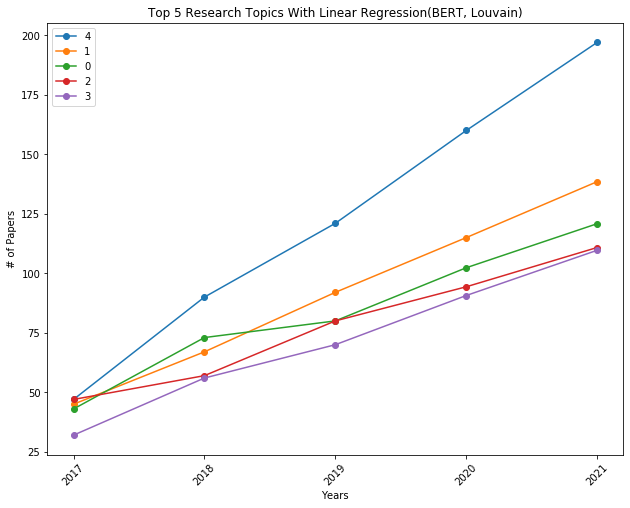

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
total_years = re_years + target
ax.set_xticks(total_years)
for i in range(5):
    plt.plot(total_years, sort_group_predict_lou[i], "o-",
             label=str(sort_group_name_lou[i])
            )
plt.legend(loc='upper left')
plt.xlabel('Years')
plt.ylabel('# of Papers')
plt.title('Top 5 Research Topics With Linear Regression(BERT, Louvain)')
plt.savefig('../image/linear_regression_paper_bert_louvain.pdf', 
            bbox_inches='tight')
plt.show()